<a href="https://colab.research.google.com/github/ZackAkil/optimising-basketball/blob/master/shot%20prediction/did_i_just_shoot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install tensorflowjs --quiet

tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.


In [3]:
!gsutil ls gs://rugby-videos

gs://rugby-videos/VID_20181215_095232.mp4
gs://rugby-videos/deltas.joblib
gs://rugby-videos/deltas.mp4
gs://rugby-videos/deltas_160.mp4
gs://rugby-videos/model.h5
gs://rugby-videos/model.json
gs://rugby-videos/model_where.h5
gs://rugby-videos/model_where.json
gs://rugby-videos/output_320_full.mp4
gs://rugby-videos/y.joblib


In [4]:
!gsutil cp gs://rugby-videos/deltas_160.mp4 .

Copying gs://rugby-videos/deltas_160.mp4...
- [1 files][  2.2 MiB/  2.2 MiB]                                                
Operation completed over 1 objects/2.2 MiB.                                      


In [0]:
!gsutil cp gs://rugby-videos/deltas.mp4 .

Copying gs://rugby-videos/deltas.mp4...
- [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      


In [0]:
DELTAS_FILE_NAME = 'deltas_160.mp4'

In [5]:
!gsutil cp gs://rugby-videos/y.joblib .

Copying gs://rugby-videos/y.joblib...
/ [1 files][ 28.4 KiB/ 28.4 KiB]                                                
Operation completed over 1 objects/28.4 KiB.                                     


In [0]:
from sklearn.externals import joblib
from scipy.misc import imresize

In [0]:
ys = joblib.load('y.joblib')

In [0]:
!pip install scikit-video --quiet

In [0]:
from skvideo.io import vread
import numpy as np

In [0]:
M = 7000

In [0]:
X_delta = vread(DELTAS_FILE_NAME)[:M,:,:,0]
X = np.expand_dims(X_delta, axis=3)
del(X_delta)

In [0]:
import sys

In [14]:
sys.getsizeof(X)

144

In [15]:
X.shape, X.dtype, X.sum()

((7000, 90, 160, 1), dtype('uint8'), 1930248067)

In [0]:
# turn y coords in to a boolean flag for 'was a shot taken'
y = ~(np.array(ys['y']) == None)[:M]

In [17]:
y.shape

(7000,)

# Augment data with translations

In [0]:
def move_image(image, x_trans):
  new_image = np.roll(image, x_trans)
  return new_image

In [0]:
plt.imshow(gray_to_channel(X_test[1]))
plt.show()

plt.imshow(gray_to_channel(move_image(X_test[0:10],-50)[1]))
plt.show()

NameError: ignored

In [21]:
y.sum(), len(y)

(711, 7000)

In [22]:
y_m = y.sum()
y_m

711

In [23]:
shot_x = X[y]
shot_x.shape, shot_x.dtype

((711, 90, 160, 1), dtype('uint8'))

In [24]:
y_m = y.sum()

shot_x = X[y]

assert(y_m == len(shot_x))



translations = (np.arange(8)*7)-25

new_data = np.zeros([8*y_m, shot_x.shape[1], shot_x.shape[2], 1]).astype(np.uint8)

for i, trans in enumerate(translations):
  from_index = i*y_m
  to_index = (i+1)*y_m
  print('writing {0} to {1}, translation of {2}'.format(from_index, to_index, trans))
  new_data[from_index:to_index] = np.roll(shot_x, trans)
  print(new_data.sum())


writing 0 to 711, translation of -25
158356684
writing 711 to 1422, translation of -18
316713368
writing 1422 to 2133, translation of -11
475070052
writing 2133 to 2844, translation of -4
633426736
writing 2844 to 3555, translation of 3
791783420
writing 3555 to 4266, translation of 10
950140104
writing 4266 to 4977, translation of 17
1108496788
writing 4977 to 5688, translation of 24
1266853472


In [25]:
new_data.shape, new_data.dtype

((5688, 90, 160, 1), dtype('uint8'))

In [26]:
len(new_data), sum(~y)

(5688, 6289)

In [27]:
X.dtype

dtype('uint8')

In [0]:
augmented_m = len(new_data) + sum(~y)
augmented_x = np.zeros([augmented_m, shot_x.shape[1], shot_x.shape[2], 1]).astype(np.uint8)
augmented_x[:sum(~y)] = X[~y]
augmented_x[sum(~y):] = new_data

In [29]:
new_data.sum(),X[~y].sum(),new_data.sum()+X[~y].sum(), augmented_x.sum()

(1266853472, 1771891383, 3038744855, 3038744855)

In [30]:
augmented_y = np.zeros(augmented_m)
augmented_y[sum(~y):] = True
augmented_y = augmented_y.astype(np.bool)
augmented_y, augmented_y.sum()

(array([False, False, False, ...,  True,  True,  True]), 5688)

In [0]:
del(X)
del(y)

In [0]:
import matplotlib.pyplot as plt

In [0]:
def show_random_frames(X, y):
  y_indexies, = np.where(y)
  random_ys = np.random.choice(y_indexies, 5)

  # confirm that our y match with frames with shots
  for index in random_ys:
    plt.imshow(X[index])
    plt.show()

In [0]:
show_random_frames(X[:,:,:,0], y)

NameError: ignored

In [0]:
show_random_frames(X[:,:,:,0], ~y)

NameError: ignored

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
y.shape

NameError: ignored

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    augmented_x, augmented_y, test_size=0.33, random_state=42)

(90, 160, 1)

In [0]:
del(augmented_x)
del(augmented_y)

In [0]:
X_train = (X_train / 255.).astype(np.float16)
X_test = (X_test / 255.).astype(np.float16)

In [38]:
X_test.dtype

dtype('float16')

In [39]:
y.shape

NameError: ignored

In [40]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [41]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
X.shape

NameError: ignored

In [0]:
input_shape = X_train.shape[1:]

In [0]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [58]:
batch_size = 128
epochs = 3

# class_weight = {True: 10.,
#                 False: 1.}

model.fit(X_train, y_train,
#           class_weight=class_weight,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 8024 samples, validate on 3953 samples
Epoch 1/3
8024/8024 [==============================] - 3s 371us/step - loss: 0.1678 - acc: 0.9868 - val_loss: 0.0276 - val_acc: 0.9997
Epoch 2/3
8024/8024 [==============================] - 3s 370us/step - loss: 0.1544 - acc: 0.9898 - val_loss: 0.0190 - val_acc: 1.0000
Epoch 3/3
8024/8024 [==============================] - 3s 369us/step - loss: 0.1486 - acc: 0.9895 - val_loss: 0.0162 - val_acc: 0.9997


In [0]:
model.predict(X_train[0:1])

array([[2.0242956e-10]], dtype=float32)

In [0]:
sum(y_test)/ len(y_test)

0.4642044017202125

In [0]:
np.where(y_test)

(array([   1,    2,    3, ..., 3946, 3951, 3952]),)

In [0]:
def gray_to_channel(image):
  new_image = np.zeros([*image.shape[:2], 3])
  new_image[:,:,0] = image.reshape(image.shape[:2])
  new_image[:,:,1] = image.reshape(image.shape[:2])
  new_image[:,:,2] = image.reshape(image.shape[:2])
  return new_image

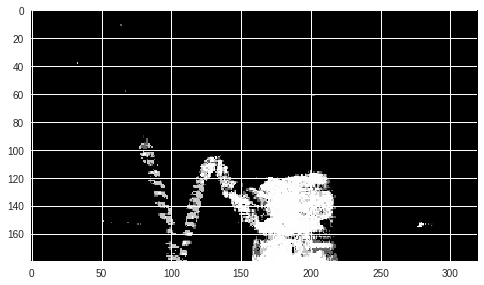

In [0]:
plt.imshow(gray_to_channel(X_test[419]))

In [0]:
[*X_test[419].shape[:2], 3]

[180, 320, 3]

In [0]:
pred, = model.predict(X_test[419:420])

In [0]:
pred[0]

3.1461167e-09

In [0]:
test = X / 255.

NameError: ignored

In [0]:
output = model.predict(X_test[:10])

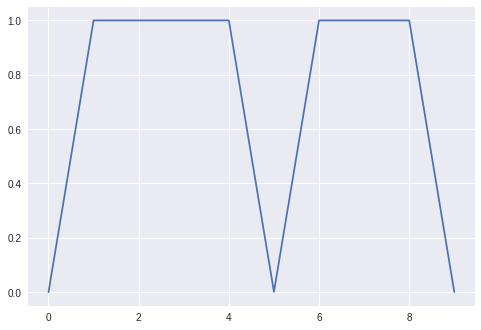

In [0]:
plt.plot(output)

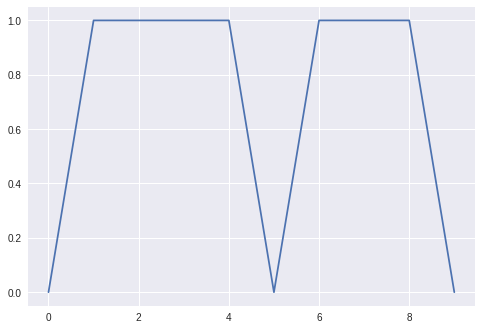

In [0]:
plt.plot(y_test[:10])

In [0]:
2000/30

66.66666666666667

In [0]:
# for i in range(0, 2000, 5):
#   frame = test[i:i+1]
#   pred, = model.predict(frame)[0]
#   if pred > 0.99:
#     print('shootiing')
  
#   plt.imshow(gray_to_channel(test[i]))
#   plt.show()

In [0]:
test_data = vread('deltas_160.mp4')[7000:9000,:,:,0]
val_test = np.expand_dims(test_data, axis=3) / 255.

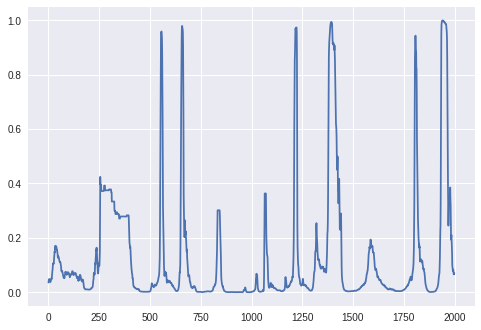

In [59]:
output = model.predict(val_test)
plt.plot(output)

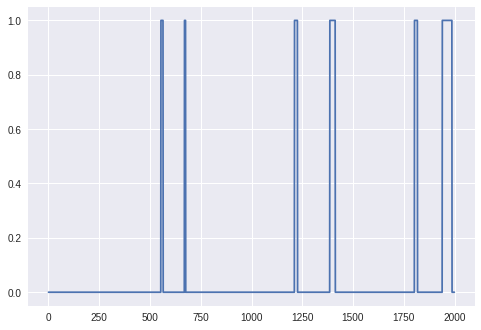

In [60]:
y_test_val = ~(np.array(ys['y']) == None)[7000:9000]
plt.plot(y_test_val)

In [0]:
import tensorflowjs as tfjs

In [0]:
tfjs.converters.save_keras_model(model, 'js')

In [63]:
! zip -r js_model.zip js

  adding: js/ (stored 0%)
  adding: js/model.json (deflated 75%)
  adding: js/group1-shard1of1 (deflated 7%)


https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Saved model to disk


In [0]:
! gsutil cp model.h5 gs://rugby-videos/model.h5

Copying file://model.h5 [Content-Type=application/octet-stream]...
/ [1 files][  1.8 MiB/  1.8 MiB]                                                
Operation completed over 1 objects/1.8 MiB.                                      


In [0]:
! gsutil cp model.json gs://rugby-videos/model.json

Copying file://model.json [Content-Type=application/json]...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 objects/2.2 KiB.                                      


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 178, 318, 4)       40        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 89, 159, 4)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 89, 159, 4)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 56604)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 452840    
_________________________________________________________________
dropout_18 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 9         
Total para

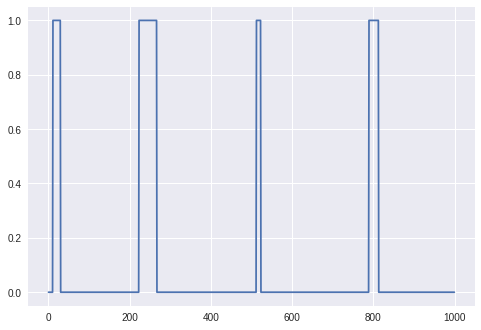

In [0]:
y_test_val = ~(np.array(ys['y']) == None)[-1000:]
plt.plot(y_test_val)